In [1]:
import json
import os
import sys

from sentence_transformers import SentenceTransformer
import torch
import torchvision.datasets as dset

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from testing import *

/home/xbuban1/llama_games_venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
available_models = [
    "all-mpnet-base-v2",
    "multi-qa-mpnet-base-dot-v1",
    "all-distilroberta-v1",
    "all-MiniLM-L12-v2",
    "multi-qa-distilbert-cos-v1",
    "all-MiniLM-L6-v2",
    "multi-qa-MiniLM-L6-cos-v1",
    "paraphrase-multilingual-mpnet-base-v2",
    "paraphrase-albert-small-v2",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "paraphrase-MiniLM-L3-v2",
    "distiluse-base-multilingual-cased-v1",
    "distiluse-base-multilingual-cased-v2"
]

scores = {model: {"similarity_score": 0, "dissimilarity_score": 0} for model in available_models}

device = torch.device("cuda:3")

ds = dset.CocoCaptions(
    root = '/home/xbuban1/coco/images/val2017',
    annFile = '/home/xbuban1/coco/annotations/captions_val2017.json'
)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [3]:
for i, model_name in enumerate(available_models):
    print(f"Processing model {model_name} ({i+1}/{len(available_models)})")
    model = SentenceTransformer(model_name, device=device)

    ds_s = get_intra_similarities_avg(model, ds)
    ds_d = get_intra_dissimilarities_avg(model, ds)

    scores[model_name]["similarity_score"] = ds_s
    scores[model_name]["dissimilarity_score"] = ds_d

    print()

Processing model all-mpnet-base-v2 (1/13)


/home/xbuban1/llama_games_venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [02:10<00:00, 38.40it/s]



Processing model multi-qa-mpnet-base-dot-v1 (2/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [02:07<00:00, 39.11it/s]



Processing model all-distilroberta-v1 (3/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:32<00:00, 54.11it/s]



Processing model all-MiniLM-L12-v2 (4/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:58<00:00, 42.37it/s]



Processing model multi-qa-distilbert-cos-v1 (5/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:30<00:00, 55.10it/s]



Processing model all-MiniLM-L6-v2 (6/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:24<00:00, 58.88it/s]



Processing model multi-qa-MiniLM-L6-cos-v1 (7/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:24<00:00, 59.05it/s]



Processing model paraphrase-multilingual-mpnet-base-v2 (8/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [02:10<00:00, 38.31it/s]



Processing model paraphrase-albert-small-v2 (9/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:27<00:00, 56.95it/s]



Processing model paraphrase-multilingual-MiniLM-L12-v2 (10/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:56<00:00, 42.99it/s]



Processing model paraphrase-MiniLM-L3-v2 (11/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:05<00:00, 76.61it/s]



Processing model distiluse-base-multilingual-cased-v1 (12/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:29<00:00, 56.09it/s]



Processing model distiluse-base-multilingual-cased-v2 (13/13)


Calculating intra-dissimilarities: 100%|██████████| 5000/5000 [01:28<00:00, 56.67it/s]

In [4]:
# Order print by similarity score
for model_name in sorted(scores, key=lambda x: scores[x]["similarity_score"], reverse=True):
    print(f"{model_name.ljust(40)} {scores[model_name]['similarity_score']:0.4f}")

multi-qa-mpnet-base-dot-v1               26.9233
paraphrase-multilingual-mpnet-base-v2    0.7506
paraphrase-multilingual-MiniLM-L12-v2    0.7222
paraphrase-MiniLM-L3-v2                  0.6598
paraphrase-albert-small-v2               0.6551
multi-qa-distilbert-cos-v1               0.6506
multi-qa-MiniLM-L6-cos-v1                0.6389
all-mpnet-base-v2                        0.6278
all-distilroberta-v1                     0.6149
all-MiniLM-L6-v2                         0.6144
all-MiniLM-L12-v2                        0.6133
distiluse-base-multilingual-cased-v2     0.5720
distiluse-base-multilingual-cased-v1     0.5639


In [5]:
# Order print by dissimilarity score
for model_name in sorted(scores, key=lambda x: scores[x]["dissimilarity_score"], reverse=False):
    print(f"{model_name.ljust(40)} {scores[model_name]['dissimilarity_score']:0.4f}")

paraphrase-MiniLM-L3-v2                  0.0347
paraphrase-albert-small-v2               0.0396
all-distilroberta-v1                     0.0610
paraphrase-multilingual-MiniLM-L12-v2    0.0635
all-MiniLM-L12-v2                        0.0777
all-MiniLM-L6-v2                         0.0899
all-mpnet-base-v2                        0.0967
paraphrase-multilingual-mpnet-base-v2    0.1082
distiluse-base-multilingual-cased-v1     0.1105
distiluse-base-multilingual-cased-v2     0.1151
multi-qa-MiniLM-L6-cos-v1                0.2401
multi-qa-distilbert-cos-v1               0.2609
multi-qa-mpnet-base-dot-v1               17.1176


In [6]:
# Order print by combined score
for model_name in sorted(scores, key=lambda x: scores[x]["similarity_score"] - scores[x]["dissimilarity_score"], reverse=True):
    print(f"{model_name.ljust(40)} {scores[model_name]['similarity_score']:0.4f} | {scores[model_name]['dissimilarity_score']:0.4f}")

multi-qa-mpnet-base-dot-v1               26.9233 | 17.1176
paraphrase-multilingual-MiniLM-L12-v2    0.7222 | 0.0635
paraphrase-multilingual-mpnet-base-v2    0.7506 | 0.1082
paraphrase-MiniLM-L3-v2                  0.6598 | 0.0347
paraphrase-albert-small-v2               0.6551 | 0.0396
all-distilroberta-v1                     0.6149 | 0.0610
all-MiniLM-L12-v2                        0.6133 | 0.0777
all-mpnet-base-v2                        0.6278 | 0.0967
all-MiniLM-L6-v2                         0.6144 | 0.0899
distiluse-base-multilingual-cased-v2     0.5720 | 0.1151
distiluse-base-multilingual-cased-v1     0.5639 | 0.1105
multi-qa-MiniLM-L6-cos-v1                0.6389 | 0.2401
multi-qa-distilbert-cos-v1               0.6506 | 0.2609


In [7]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"

with open('captions/coco/3.1_val_224_no_merge.json') as f:
    val_224_no_merge_captions = json.load(f)

with open('captions/coco/3.1_val_224_merge.json') as f:
    val_224_merge_captions = json.load(f)

with open('captions/coco/3.1_val_448_no_merge.json') as f:
    val_448_no_merge_captions = json.load(f)

with open('captions/coco/3.1_val_448_merge.json') as f:
    val_448_merge_captions = json.load(f)

with open('captions/coco/finetune.json') as f:
    finetune_captions = json.load(f)

with open('captions/coco/ved.json') as f:
    ved_captions = json.load(f)

model = SentenceTransformer(model_name, device=device)

ds_similarities = get_intra_similarities(model, ds)
ds_avg_sim = torch.cat(ds_similarities).mean(dim=0)
ds_similarities = [sim.mean() for sim in ds_similarities]

ved_similarities = get_similarities(model, ds, ved_captions)
ved_avg_sim = torch.cat(ved_similarities).mean(dim=0)
ved_similarities = [sim.mean() for sim in ved_similarities]

val_224_no_merge_similarities = get_similarities(model, ds, val_224_no_merge_captions)
val_224_no_merge_avg_sim = torch.cat(val_224_no_merge_similarities).mean(dim=0)
val_224_no_merge_similarities = [sim.mean() for sim in val_224_no_merge_similarities]

val_224_merge_similarities = get_similarities(model, ds, val_224_merge_captions)
val_224_merge_avg_sim = torch.cat(val_224_merge_similarities).mean(dim=0)
val_224_merge_similarities = [sim.mean() for sim in val_224_merge_similarities]

val_448_merge_similarities = get_similarities(model, ds, val_448_merge_captions)
val_448_merge_avg_sim = torch.cat(val_448_merge_similarities).mean(dim=0)
val_448_merge_similarities = [sim.mean() for sim in val_448_merge_similarities]

val_448_no_merge_similarities = get_similarities(model, ds, val_448_no_merge_captions)
val_448_no_merge_avg_sim = torch.cat(val_448_no_merge_similarities).mean(dim=0)
val_448_no_merge_similarities = [sim.mean() for sim in val_448_no_merge_similarities]

finetune_similarities = get_similarities(model, ds, finetune_captions)
finetune_avg_sim = torch.cat(finetune_similarities).mean(dim=0)
finetune_similarities = [sim.mean() for sim in finetune_similarities]

print(f"\nIntra Captions similarity score: {ds_avg_sim:0.4f}")
print(f"VED Captions similarity score: {ved_avg_sim:0.4f}")
print(f"Val 224 No Merge Captions similarity score: {val_224_no_merge_avg_sim:0.4f}")
print(f"Val 224 Merge Captions similarity score: {val_224_merge_avg_sim:0.4f}")
print(f"Val 448 No Merge Captions similarity score: {val_448_no_merge_avg_sim:0.4f}")
print(f"Val 448 Merge Captions similarity score: {val_448_merge_avg_sim:0.4f}")
print(f"Finetuned Captions similarity score: {finetune_avg_sim:0.4f}")

Calculating similarities: 100%|██████████| 5000/5000 [01:34<00:00, 52.81it/s]


Intra Captions similarity score: 0.7222
VED Captions similarity score: 0.6799
Val 224 No Merge Captions similarity score: 0.6532
Val 224 Merge Captions similarity score: 0.6761
Val 448 No Merge Captions similarity score: 0.1988
Val 448 Merge Captions similarity score: 0.6464
Finetuned Captions similarity score: 0.6882


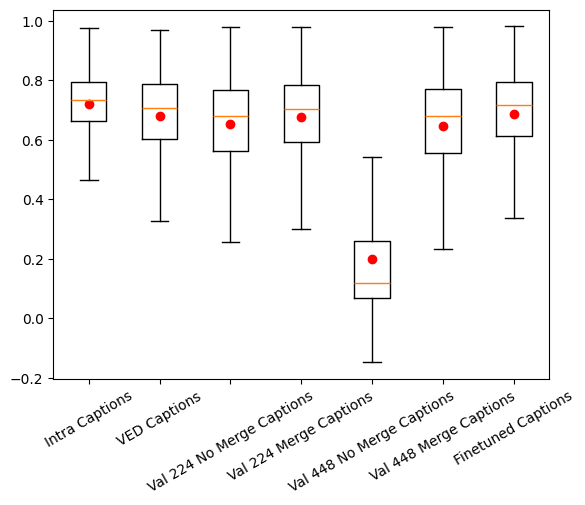

In [8]:
boxplot_similarities(
    [ds_similarities, ved_similarities, val_224_no_merge_similarities, val_224_merge_similarities, val_448_no_merge_similarities, val_448_merge_similarities, finetune_similarities],
    [ds_avg_sim, ved_avg_sim, val_224_no_merge_avg_sim, val_224_merge_avg_sim, val_448_no_merge_avg_sim, val_448_merge_avg_sim, finetune_avg_sim],
    ["Intra Captions", "VED Captions", "Val 224 No Merge Captions", "Val 224 Merge Captions", "Val 448 No Merge Captions", "Val 448 Merge Captions", "Finetuned Captions"],
)